In [1]:
import json
from datetime import datetime, timedelta
import pathlib
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

linkSequentialData = 'data/sequential_data'
operations = ['network_create_delete', 'boot_delete', 'image_create_delete']

def loadJson(link):
    with open(link) as f:
      data = json.load(f)
    return data

traces = {}

for operation in operations:
    path = pathlib.Path().absolute().parent / linkSequentialData / 'traces' / operation
    pathesTraces = list(path.glob('*.json'))
    traces[operation] = {}
    traces[operation]['link'] = pathesTraces
    traces[operation]['name'] = list(map(lambda x: x.name[:x.name.find('.json')], traces[operation]['link']))
    traces[operation]['data'] = list(map(lambda x: loadJson(x), traces[operation]['link']))

In [2]:
#print(json.dumps(traces[operations[0]]['data'][805], indent=2))

In [3]:
# the class for trace data
class Trace(object):
    def __init__(self, operation, host, name, service, project, startTimestamp, endTimestamp, traceID, parentID, baseID):
        self.operation = operation
        self.host = host
        self.name = name
        self.service = service
        self.project = project
        self.startTimestamp = datetime.strptime(startTimestamp, '%Y-%m-%dT%H:%M:%S.%f')
        if endTimestamp != 'Null':
            self.endTimestamp = datetime.strptime(endTimestamp, '%Y-%m-%dT%H:%M:%S.%f')
            self.duration = self.endTimestamp - self.startTimestamp
        else: 
            self.endTimestamp = 'Null'
            self.duration = 'Null'
        self.traceID = traceID
        self.parentID = parentID
        self.baseID = baseID
    def __repr__(self):
        return 'operation: ' + self.operation + '\nhost: ' + self.host + '\nname: ' + self.name + '\nservice: ' + self.service + '\nproject: ' + self.project + '\nstartTimestamp: ' + str(self.startTimestamp) + '\nendTimestamp: ' + str(self.endTimestamp) + '\nduration: ' + str(self.duration) + '\ntraceID: ' + self.traceID + '\nparentID: ' + self.parentID + '\nbaseID: ' + self.baseID + '\n'
    def __str__(self):
        return 'operation: ' + self.operation + '\nhost: ' + self.host + '\nname: ' + self.name + '\nservice: ' + self.service + '\nproject: ' + self.project + '\nstartTimestamp: ' + str(self.startTimestamp) + '\nendTimestamp: ' + str(self.endTimestamp) + '\nduration: ' + str(self.duration) + '\ntraceID: ' + self.traceID + '\nparentID: ' + self.parentID + '\nbaseID: ' + self.baseID + '\n'

In [4]:
# parse of json data to trace object
def parseTrace(operation, df):
    traces = []
    for item in df['children']:
        traces.append(Trace(operation,
                            item.get('info').get('host'), 
                            item.get('info').get('name'),
                            item.get('info').get('service'),
                            item.get('info').get('project'), 
                            item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('timestamp'), 
                            item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', {'timestamp': 'Null'}).get('timestamp'), 
                            item.get('trace_id'), 
                            item.get('parent_id'), 
                            item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id')))
        if len(item['children']) != 0:
            traces = traces + parseTrace(operation, item)
    return traces

for operation in operations:
    traces[operation]['parsedData'] = list(map(lambda x: parseTrace(operation, x), traces[operation]['data']))

In [5]:
# check repetitions in trace's structure 
noRepetitions = False
def checkRepetitionsInTrace(df):
    for item in df['children']:
        
        mockField = {'info': {'host': item.get('info').get('host')},
                    'service': item.get('info').get('service'),
                    'project': item.get('info').get('project'),
                    'parent_id': item.get('parent_id'),
                    'base_id': item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('base_id'),
                    'trace_id': item.get('trace_id')
                    }
        
        if (item.get('info').get('service') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', mockField).get('service')) or (item.get('info').get('service') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('service')):
            noRepetitions = True
            print('service in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id'))
        
        if (item.get('info').get('project') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', mockField).get('project')) or (item.get('info').get('project') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('project')):
            noRepetitions = True
            print('project in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id'))
        
        if (item.get('info').get('host') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', mockField).get('info').get('host')) or (item.get('info').get('host') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('info').get('host')):
            noRepetitions = True
            print('host in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id'))
            
        if (item.get('parent_id') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', mockField).get('parent_id')) or (item.get('parent_id') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('parent_id')):
            noRepetitions = True
            print('parent_id in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id'))
        
        if (item.get('trace_id') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', mockField).get('trace_id')) or (item.get('trace_id') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('trace_id')):
            noRepetitions = True
            print('trace_id in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id'))
        
        if (item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', mockField).get('base_id') != item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('base_id')):
            noRepetitions = True
            print('base_id in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id')) 
        
        if len(item['children']) != 0:
            checkRepetitionsInTrace(item)

for operation in operations:
    for x in traces[operation]['data']:
        checkRepetitionsInTrace(x)
        
if not(noRepetitions):
    print('All host, service, project, parent_id, base_id, trace_id fields in each span are redundante')

All host, service, project, parent_id, base_id, trace_id fields in each span are redundante


In [6]:
# collect all values of node's attributes
hosts = []
names = []
services = []
projects = []

for operation in operations:
    for arr in traces[operation]['parsedData']:
        for x in arr:
            if x.host not in hosts:
                hosts.append(x.host)
            if x.name not in names:
                names.append(x.name)
            if x.service not in services:
                services.append(x.service)
            if x.project not in projects:
                projects.append(x.project)
                
print('hosts =', hosts)
print('names =', names)
print('services =', services)
print('projects =', projects)

hosts = ['wally113', 'wally122', 'wally117', 'wally124']
names = ['wsgi', 'db', 'neutron.db', 'rpc', 'compute_api', 'nova_image', 'neutron_api']
services = ['public', 'neutron-server', 'neutron-dhcp-agent', 'osapi_compute', 'api', 'nova-conductor', 'nova-scheduler', 'nova-compute']
projects = ['keystone', 'neutron', 'nova', 'glance']


In [7]:
# collect all values of json's attribute name
infoNames = []

for operation in operations:
    for item in traces[operation]['data']:
        if item.get('info').get('name') not in infoNames:
            infoNames.append(item.get('info').get('name'))

print('info names =', infoNames)

info names = ['total']


In [8]:
# remove microseconds of timestamp
def removeMicroseconds(x):
    return datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f').replace(microsecond = 0)

timeStart = datetime.strptime('2019-11-19 17:38:39', '%Y-%m-%d %H:%M:%S')
timeEnd = datetime.strptime('2019-11-20 01:30:00', '%Y-%m-%d %H:%M:%S')

noTimestampOutside = True
# check all timestamps for range of the experiment time
def checkTimestamps(df):
    for item in df['children']:
        
        ts = removeMicroseconds(item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('timestamp'))
        if not((ts >= timeStart) and (ts <= timeEnd)):
            noTimestampOutside = False
            print('time out the range in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id'))
        
        te = item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', {'timestamp': 'Null'}).get('timestamp')
        if te != 'Null':
            te = removeMicroseconds(te)
            if not((te >= timeStart) and (te <= timeEnd)):
                noTimestampOutside = False
                print('time out the range in', item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id'), 'trace_id =', item.get('trace_id'))

        if len(item['children']) != 0:
            checkTimestamps(item)

for operation in operations:            
    for x in traces[operation]['data']:
        checkTimestamps(x)
        
if noTimestampOutside:
    print('There are not timestamps outside of the experiment time')

There are not timestamps outside of the experiment time


In [9]:
# find the max trace duration
m = timedelta(0)
for operation in operations:
    for arr in traces[operation]['parsedData']:
        for x in arr:
            if x.duration != 'Null':
                m = max(m, x.duration)

print('Max duration of span is', m)

Max duration of span is 0:02:50.162165


In [10]:
# calculate number of traces per second
allTimestamps = pd.date_range(timeStart, timeEnd, freq = 'S')
allTimestamps.freq = None
allTimestamps = list(allTimestamps)

countTimestampPerSecond = {timestamp : {'number' : 0,
                                       'hosts' : []} for timestamp in allTimestamps}

def countTraces(arr, item):
    for x in arr:
        countTimestampPerSecond[x]['number'] += 1
        if item.host not in countTimestampPerSecond[x]['hosts']:
            countTimestampPerSecond[x]['hosts'].append(item.host)

for operation in operations:
    for arr in traces[operation]['parsedData']:
        for x in arr:
            ts = x.startTimestamp.replace(microsecond = 0)
            if x.duration != 'Null':
                te = x.endTimestamp.replace(microsecond = 0)
                if ts != te:
                    at = pd.date_range(ts, te, freq = 'S')
                    at.freq = None
                    at = list(at)
                    countTraces(at, x)
                else:
                    countTraces([ts], x)
            else:
                countTraces([ts], x)

print('The number of spans is', sum(len(arr) for i in range(len(operations)) for arr in traces[operations[i]]['parsedData']))
print('The max number of active spans per second is', max(value['number'] for key, value in countTimestampPerSecond.items()))
print('The average number of active spans per second is', int(sum(value['number'] for key, value in countTimestampPerSecond.items())/len(list(key for key, value in countTimestampPerSecond.items()))))
print('The number of seconds without spans is', sum(value['number'] == 0 for key, value in countTimestampPerSecond.items()))

The number of spans is 829562
The max number of active spans per second is 473
The average number of active spans per second is 30
The number of seconds without spans is 11450


In [11]:
# calculate list of free seconds for each node
hostNames = ['wally113', 'wally122', 'wally117', 'wally124', 'wally123']
gaps = {host: [] for host in hostNames}
for key, value in countTimestampPerSecond.items():
    for host in list(set(hostNames) - set(value['hosts'])):
        gaps[host].append(key)

for key, value in gaps.items():
    print('The node ', key, ' has ', len(value), ' (',round(len(value)/len(allTimestamps) * 100, 2),'%) ', 'seconds without spans', sep = '')

The node wally113 has 11642 (41.16%) seconds without spans
The node wally122 has 25948 (91.75%) seconds without spans
The node wally117 has 26868 (95.0%) seconds without spans
The node wally124 has 26031 (92.04%) seconds without spans
The node wally123 has 28282 (100.0%) seconds without spans


In [12]:
# get the start timestamp of the parent trace
def getTimeOfParent(parentID, arr):
    for item in arr:
        if item.traceID == parentID:
            return item.startTimestamp
    return 'Null'

# create the graph from list of trace objects
def createGraph(arr):
    trace = nx.DiGraph()
    for item in arr:
        trace.add_node(item.traceID, 
                       host = item.host, 
                       name = item.name, 
                       project = item.project, 
                       startTimestamp = item.startTimestamp, 
                       endTimestamp = item.endTimestamp,
                       duration = item.duration, 
                       traceID = item.traceID, 
                       parentID = item.parentID,
                       baseID = item.baseID)
        if item.baseID != item.parentID:
            trace.add_edge(item.parentID, item.traceID,
                          delay = item.startTimestamp - getTimeOfParent(item.parentID, arr))
        else:
            trace.add_edge(item.parentID, item.traceID)
    return trace

for operation in operations:
    traces[operation]['graph'] = list(map(lambda x: createGraph(x), traces[operation]['parsedData']))

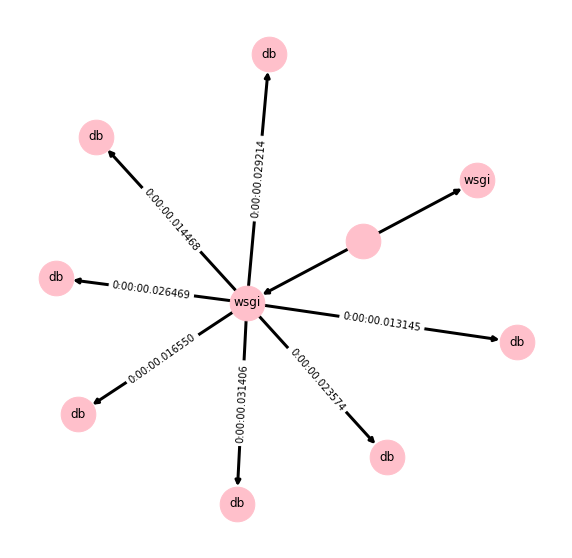

In [13]:
# example of the smallest trace json file
g = traces[operations[0]]['graph'][805]

plt.figure(figsize=(10, 10)) 
pos = nx.spring_layout(g)
nx.draw_networkx_labels(g, pos, nx.get_node_attributes(g, 'name'))
nx.draw_networkx_edge_labels(g, pos, nx.get_edge_attributes(g, 'delay'))
nx.draw(g, pos = pos, node_color = 'pink', node_size = 1200, font_size = 14, width = 3)
plt.show()

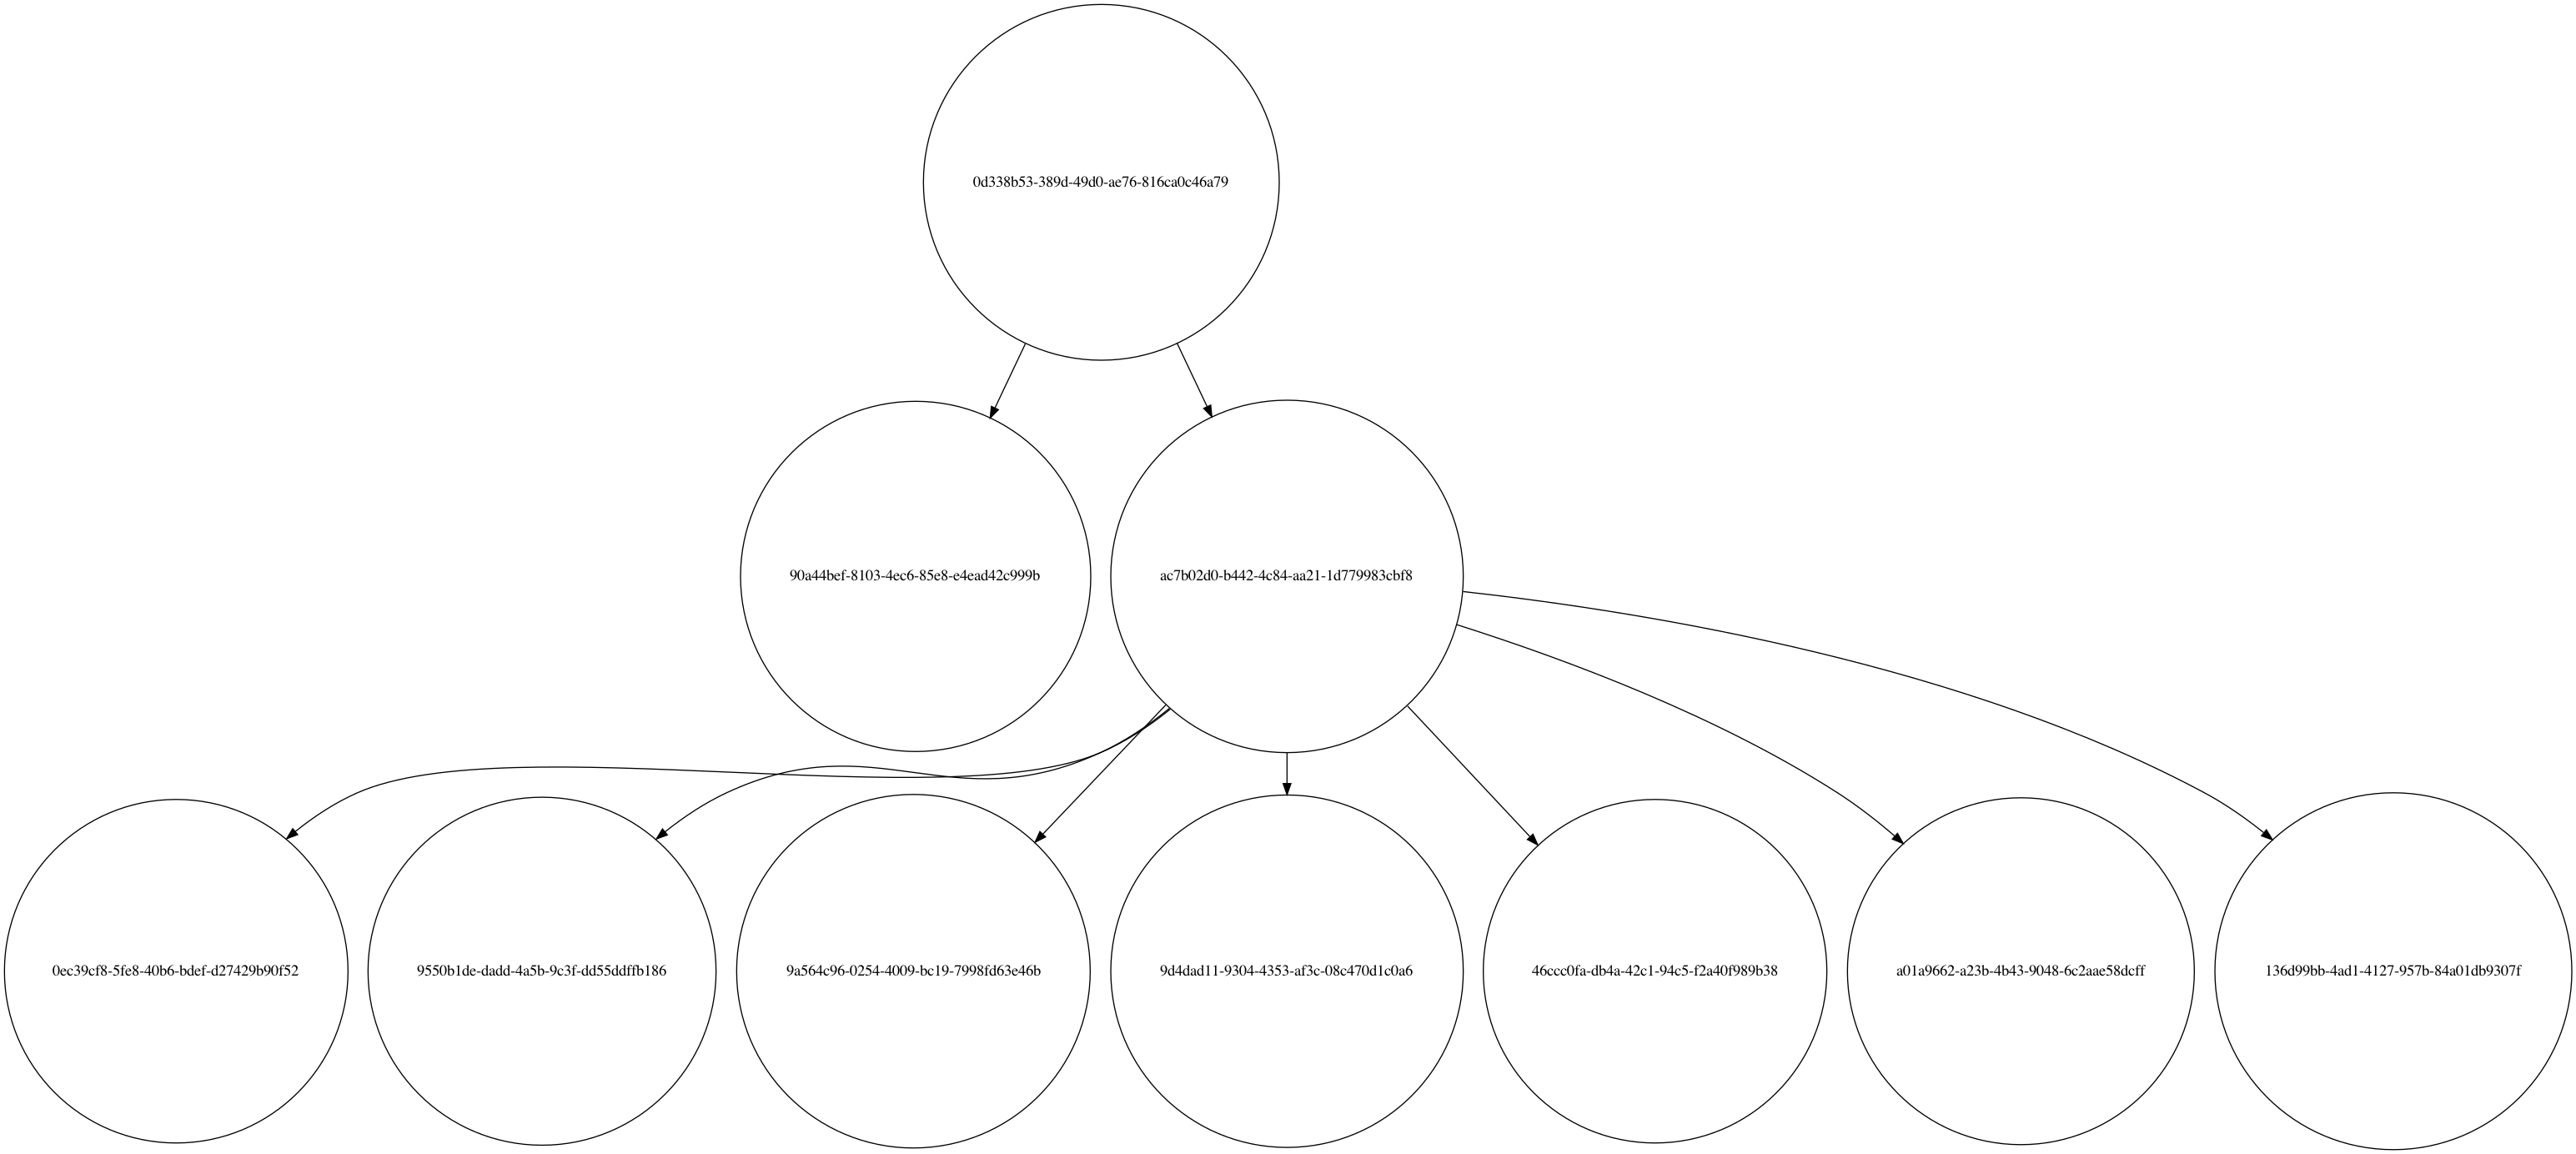

In [14]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
from IPython.display import Image

g.graph['graph'] = {'rankdir':'TD'}
g.graph['node'] = {'shape':'circle'}
g.graph['edges'] = {'arrowsize':'1.0'}
A = to_agraph(g)
A.layout('dot')
A.draw('a.png')
Image(filename='a.png')